In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

# 1. Embedding Network
- 16차원을 임계값으로 저차원/ 고차원 결정
- 고차원 데이터의 경우 16으로 (네트워크의 입력 및 출력 특징 크기는 (입력 크기, 256), (256, 64), (64, 16))
- 저차원 데이터의 경우는 2로 ((입력 크기, 64), (64, 16), (16, 2))함.
- 모든 은닉층에 사용되는 활성화 함수는 ReLU이며, 출력층의 활성화 함수는 시그모이드 함수를 사용.

In [2]:
class HighDimAutoencoder(nn.Module):
  def __init__(self, input_dim):
    super(HighDimAutoencoder, self).__init__()
    # 인코더
    self.encoder = nn.Sequential(
        nn.Linear(input_dim, 256),
        nn.ReLU(),
        nn.Linear(256, 64),
        nn.ReLU(),
        nn.Linear(64, 16)
    )
    # 디코더
    self.decoder = nn.Sequential(
        nn.Linear(16, 64),
        nn.ReLU(),
        nn.Linear(64, 256),
        nn.ReLU(),
        nn.Linear(256, input_dim),
        nn.Sigmoid()
    )
  def forward(self, x):
    z = self.encoder(x)
    x_hat = self.decoder(z)
    return z, x_hat

class LowDimAutoencoder(nn.Module):
    def __init__(self, input_dim):
        super(LowDimAutoencoder, self).__init__()
        # 인코더
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 16),
            nn.ReLU(),
            nn.Linear(16, 2)
        )
        # 디코더
        self.decoder = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Linear(16, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return z, x_hat

def select_autoencoder(data):
    input_dim = data.shape[1]
    if input_dim > 16:
        model = HighDimAutoencoder(input_dim)
        latent_dim = 16 # 추후 FC layer에 사용
    else:
        model = LowDimAutoencoder(input_dim)
        latent_dim = 2
    return model, latent_dim


## 1-1. 데이터 생성

In [3]:
# MNIST 데이터셋 로드
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784')
X, y = mnist['data'], mnist['target']

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


## 1-2. 데이터 전처리

In [4]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch

# 숫자 0과 6만 선택
mask = (y == '0') | (y == '6')
X_filtered, y_filtered = X[mask], y[mask]

# 데이터 정규화 및 텐서 변환
X_filtered = (X_filtered / 255.0).astype(np.float32) # 정규화
y_filtered = (y_filtered == '6').astype(int) # 6인 레이블을 1로 변환
X_filtered = torch.tensor(X_filtered.values)
y_filtered = torch.tensor(y_filtered.values)

## 1-3. 데이터 검증

## 1-3-1. 각 클래스 별 데이터를 먼저 확인해보자

In [5]:
num_class_0 = len(y_filtered[y_filtered == 0])
num_class_1 = len(y_filtered[y_filtered == 1])
print(f"클래스 0의 샘플 수: {num_class_0}")
print(f"클래스 1의 샘플 수: {num_class_1}")

클래스 0의 샘플 수: 6903
클래스 1의 샘플 수: 6876



##1-3-2. 엥 차이가 없네?
image.png

- 논문에서는 6의 데이터(여기선 클래스 1)를 700으로 줄임
- 줄여보자

In [6]:
indices_class_1 = np.where(y_filtered == 1)[0] # class가 1인 인덱스 찾기
np.random.seed(0) # 재검증을 위한 시드 설정
selected_indices_class_1 = np.random.choice(indices_class_1, 700, replace=False) # 700개 랜덤으로 찾기

indices_class_0 = np.where(y_filtered == 0)[0] # class가 0인 인덱스 찾기
selected_indices = np.concatenate((indices_class_0, selected_indices_class_1))  # 둘을 합쳐 최종 인덱스 조합 생성

# 데이터와 레이블 필터링
data = X_filtered[selected_indices]
labels = y_filtered[selected_indices]

# 데이터 크기 확인
print("X_tensor shape:", data.shape)
print("y_tensor shape:", labels.shape)

# 각 클래스 샘플 수 확인
num_class_0 = len(labels[labels == 0])
num_class_1 = len(labels[labels == 1])
print(f"클래스 0의 샘플 수: {num_class_0}")
print(f"클래스 1의 샘플 수: {num_class_1}")

X_tensor shape: torch.Size([7603, 784])
y_tensor shape: torch.Size([7603])
클래스 0의 샘플 수: 6903
클래스 1의 샘플 수: 700


## 1-3-3. 나중에 쓸 오버샘플링 비율도 미리 계산해보자

In [7]:
# 오버샘플링 비율 계산
over_sampling_ratio = num_class_0 / num_class_1
print(f"오버샘플링 비율: {over_sampling_ratio}")

오버샘플링 비율: 9.861428571428572


## 1-3-4. 시각화도 해보자

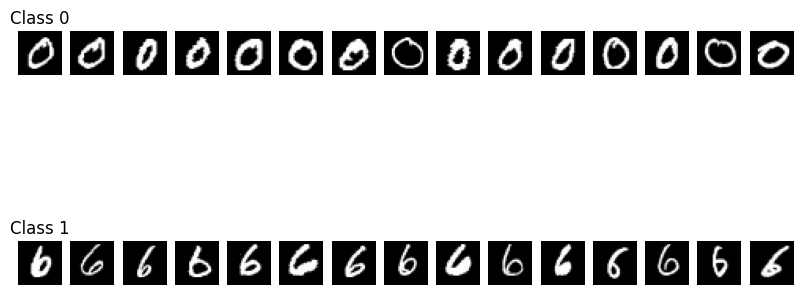

In [8]:
import matplotlib.pyplot as plt

# 5. 데이터 시각화 (각 클래스의 일부 샘플 보기)
def plot_samples(data, labels, num_samples=15):
    fig, axes = plt.subplots(2, num_samples, figsize=(10, 5))
    classes = [0, 1]
    for i, cls in enumerate(classes):
        cls_data = data[labels == cls]
        for j in range(num_samples):
            axes[i, j].imshow(cls_data[j].reshape(28, 28), cmap='gray')
            axes[i, j].axis('off')
            if j == 0:
                axes[i, j].set_title(f"Class {cls}")

plot_samples(data.numpy(), labels.numpy())
plt.show()

## 1-2. 인코더 적용해보자

In [9]:
autoencoder, latent_dim = select_autoencoder(data)
z, x_hat = autoencoder(data)

## 1-2-1. 인코더 적용 후 시각화 (그냥 한 번 봐보자)

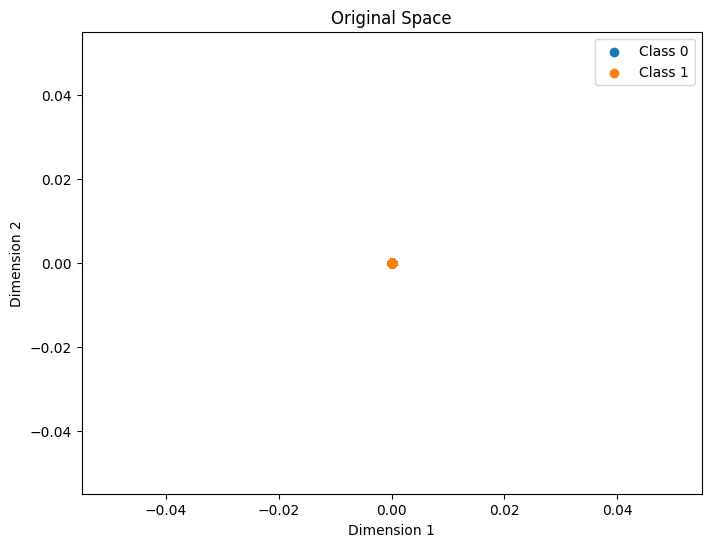

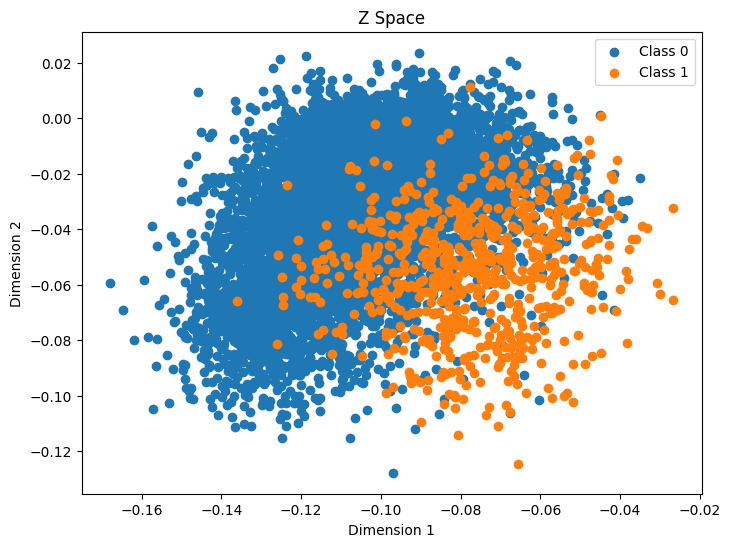

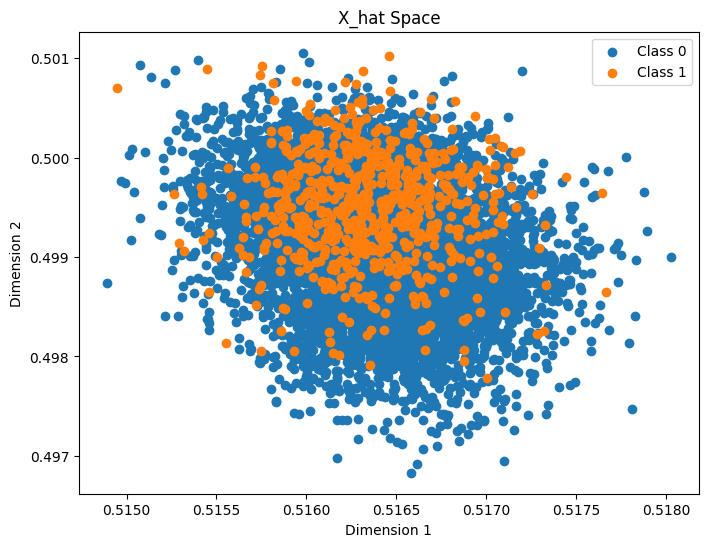

In [10]:
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# 원본 데이터 시각화 (10차원이여서 의미없긴 한데)
plt.figure(figsize=(8, 6))
for label in torch.unique(labels):
    idx = labels == label
    plt.scatter(data[idx, 0], data[idx, 1], label=f'Class {label.item()}')
plt.title('Original Space')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()
plt.show()

# z 시각화
z = z.detach().numpy()
plt.figure(figsize=(8, 6))
for label in torch.unique(labels):
    idx = labels == label
    plt.scatter(z[idx, 0], z[idx, 1], label=f'Class {label.item()}')
plt.title('Z Space')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()
plt.show()


# x_hat 시각화 (10차원이여서 의미없긴 한데)
x_hat = x_hat.detach().numpy()
plt.figure(figsize=(8, 6))
for label in torch.unique(labels):
    idx = labels == label
    plt.scatter(x_hat[idx, 0], x_hat[idx, 1], label=f'Class {label.item()}')
plt.title('X_hat Space')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()
plt.show()

In [11]:
print(x_hat.shape)
print(z.shape)
print(data.shape)

(7603, 784)
(7603, 16)
torch.Size([7603, 784])


## 1-3. z에 Fully-connected Layer 연결 (z의 클래스 예측)

In [13]:
class Classifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(Classifier, self).__init__()
        self.fc = nn.Linear(input_dim, num_classes)

    def forward(self, x):
        return self.fc(x)

classifier = Classifier(input_dim=latent_dim, num_classes=2)

# 2. Loss function
- Reconstruction Loss = x, x_hat 간의 MSE
- between-class loss = z를 Fully-connected Layer을 한 y_hat과 y의 교차 엔트로피 손실
- within-class loss = 잠재 공간에서 yi 클래스의 중심인 Cyi와 zi의 L2규제의 배치 사이즈 합의 1/2

In [14]:
# Reconstruction Loss
reconstruction_criterion = nn.MSELoss()

# between-class loss
classification_criterion = nn.CrossEntropyLoss()

# within_class loss
# 클래스 중심(Cyi) 계산
def compute_class_centers(z, labels, num_classes):
    centers = torch.zeros(num_classes, z.size(1))
    for i in range(num_classes):
        class_points = z[labels == i] # bealean (label이 i일 때 해당하는 인덱스를 z에서 찾음, i이면 True, 아니면 False)
        if len(class_points) > 0: # label에 맞는 데이터가 1 이상이면,
            centers[i] = class_points.mean(dim=0) # 그 데이터의 평균을 구함. (이것이 클래스 중심.)
    return centers

def within_class_loss(z, labels, centers):
    loss = 0
    for i in range(len(z)):
        center = centers[labels[i]]
        loss += torch.norm(z[i] - center, p=2) ** 2
    return loss / 2


## 2-1. Embedding Network training
- optimizer는 논문에 나오지 않아서 Adam으로 구현
- 이를 통해 z_m, z_n을 얻음.

In [15]:
# 모델 학습
epochs = 150
num_classes = 2
optimizer = optim.Adam(list(autoencoder.parameters()) + list(classifier.parameters()), lr=1e-3)
for epoch in range(epochs):
    autoencoder.train()
    classifier.train()

    optimizer.zero_grad()

    # Forward pass
    z, x_hat = autoencoder(data)
    y_hat = classifier(z)

    # 손실 계산
    reconstruction_loss = reconstruction_criterion(x_hat, data)
    classification_loss = classification_criterion(y_hat, labels)
    class_centers = compute_class_centers(z, labels, num_classes)
    within_loss = within_class_loss(z, labels, class_centers)

    total_loss = reconstruction_loss + classification_loss + within_loss
    total_loss.backward()

    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Total Loss: {total_loss.item():.4f}, Reconstruction Loss: {reconstruction_loss.item():.4f}, Classification Loss: {classification_loss.item():.4f}, Within-Class Loss: {within_loss.item():.4f}')

    # 학습된 잠재 공간 z 시각화
    autoencoder.eval()
    with torch.no_grad():
        _, z = autoencoder(data)
        z = z.detach().numpy()
        plt.figure(figsize=(8, 6))
        for label in torch.unique(labels):
            idx = labels == label
            plt.scatter(z[idx, 0], z[idx, 1], label=f'Class {label.item()}')
        plt.title('Latent Space (Z)')
        plt.xlabel('Dimension 1')
        plt.ylabel('Dimension 2')
        plt.legend()
        plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [43]:
# 학습된 임베딩 네트워크 통해 잠재 데이터 포인트 z_i 얻기
autoencoder.eval()
with torch.no_grad():
    z, _ = autoencoder(data)

# Z_M (다수 클래스)와 Z_N (소수 클래스) 분리
z_majority = z[labels == 0]  # 다수 클래스
z_minority = z[labels == 1]  # 소수 클래스

In [44]:
print(z_majority)
print(z_majority.shape)
print(z_minority)
print(z_minority.shape)

tensor([[-0.2639,  0.1145, -0.2708,  ..., -0.1994,  0.1862, -0.0804],
        [-0.2643,  0.1149, -0.2706,  ..., -0.1996,  0.1863, -0.0803],
        [-0.2639,  0.1145, -0.2708,  ..., -0.1994,  0.1862, -0.0804],
        ...,
        [-0.2637,  0.1143, -0.2709,  ..., -0.1994,  0.1861, -0.0805],
        [-0.2648,  0.1156, -0.2704,  ..., -0.1998,  0.1865, -0.0800],
        [-0.2637,  0.1143, -0.2709,  ..., -0.1994,  0.1861, -0.0805]])
torch.Size([6903, 16])
tensor([[-0.2642,  0.1149, -0.2707,  ..., -0.1996,  0.1863, -0.0803],
        [-0.2631,  0.1135, -0.2712,  ..., -0.1991,  0.1859, -0.0808],
        [-0.2637,  0.1143, -0.2709,  ..., -0.1994,  0.1861, -0.0805],
        ...,
        [-0.2633,  0.1138, -0.2711,  ..., -0.1992,  0.1860, -0.0807],
        [-0.2639,  0.1144, -0.2708,  ..., -0.1994,  0.1862, -0.0804],
        [-0.2641,  0.1147, -0.2707,  ..., -0.1995,  0.1862, -0.0803]])
torch.Size([700, 16])


# 3. Density-Based Filtering
- 일단, 가우시안 필터 KDE를 통해 밀도를 계산함.
- bandwidth(h)계산은 scott 규칙 사용.
- z_majority 경우 두 번째 사분위 (Q2, 그러니까 상위 50%) 이상의 밀도의 샘플을 선택
- z_minority 경우 세 번째 사분위(Q3, 그러니까 상위 25%) 이상의 밀도의 샘플을 선택

In [33]:
import numpy as np
from sklearn.neighbors import KernelDensity
from scipy.stats import iqr

In [45]:
# KDE를 통한 밀도 계산
def compute_density(data):
    # Scott's rule for bandwidth
    data = data.numpy()
    m, d = data.shape # m = 샘플 수, d = 차원 수
    bandwidth = np.power(m, -1./(d+4)) * np.std(data, axis=0, ddof=1).mean()
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(data)
    log_density = kde.score_samples(data)
    return np.exp(log_density)

# # KDE를 통한 밀도 계산 (논문에 나온 scott's rule)
# def compute_density(data):
#     # Scott's rule for bandwidth
#     m, d = data.shape # m = 샘플 수, d = 차원 수
#     bandwidth = np.power(m, -1./(d+4))
#     kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(data)
#     log_density = kde.score_samples(data)
#     return np.exp(log_density)

density_majority = compute_density(z_majority)
density_minority = compute_density(z_minority)

kde ============================ KernelDensity(bandwidth=0.00012105771607181181)
log_density ==================== [127.12446246 127.6556977  127.15085091 ... 126.62030513 126.35156999
 126.51721309]
kde ============================ KernelDensity(bandwidth=0.00016171241961576255)
log_density ==================== [122.95608598 120.92624747 122.98891925 122.92261958 122.93843798
 122.93323598 123.02520879 122.97612952 122.22914961 121.51889185
 121.836873   123.21072531 123.17180789 123.22074841 122.71779163
 122.91179072 123.07769538 123.20579177 123.23166178 122.01175896
 122.68220906 122.90725126 122.55768073 123.12960242 121.51449096
 121.13092891 122.77710833 123.03004421 121.96386567 122.93541212
 123.05363353 121.54692741 118.94959641 123.01166055 123.06012965
 122.01311398 123.19990617 123.00858329 123.21953855 122.99687172
 123.215374   121.69347302 122.94616278 122.68019712 122.2724437
 122.87511612 121.80916348 122.72344157 122.09169867 123.23273552
 122.67507737 122.69621397 1

In [47]:
print(density_majority) # 값이 클수록, 데이터 포인트가 많이 모여있는 곳임.
print(density_majority.shape) # (6903,)
print(density_minority) # 값이 클수록, 데이터 포인트가 많이 모여있는 곳임.
print(density_minority.shape) # (700, )

[1.61976705e+55 2.75527590e+55 1.66307916e+55 ... 9.78362534e+54
 7.47807172e+54 8.82526005e+54]
(6903,)
[2.50697301e+53 3.29307783e+52 2.59065134e+53 2.42446202e+53
 2.46311806e+53 2.45033820e+53 2.68639155e+53 2.55772858e+53
 1.21183978e+53 5.95640441e+52 8.18618653e+52 3.23398585e+53
 3.11054503e+53 3.26656337e+53 1.97542132e+53 2.39834949e+53
 2.83115696e+53 3.21807014e+53 3.30240784e+53 9.75065172e+52
 1.90636662e+53 2.38748695e+53 1.68315633e+53 2.98199486e+53
 5.93024854e+52 4.04104805e+52 2.09614177e+53 2.69941283e+53
 9.29466740e+52 2.45567628e+53 2.76384715e+53 6.12575841e+52
 4.56197965e+51 2.65024111e+53 2.78185987e+53 9.76387300e+52
 3.19918550e+53 2.64209816e+53 3.26261368e+53 2.61133554e+53
 3.24905462e+53 7.09257303e+52 2.48221883e+53 1.90253497e+53
 1.26545757e+53 2.31198436e+53 7.96246513e+52 1.98661392e+53
 1.05621181e+53 3.30595567e+53 1.89281936e+53 1.93325294e+53
 2.79241232e+53 3.30024055e+53 8.45895358e+52 2.64635199e+53
 2.29865224e+53 1.53536110e+53 1.15240293

In [48]:
# 사분위수 계산
q2_majority = np.percentile(density_majority, 50)  # 두 번째 사분위수 (Q2, 상위 50%)
q3_minority = np.percentile(density_minority, 75)  # 세 번째 사분위수 (Q3, 상위 25%)

# 상위 밀도 샘플 선택
high_density_majority = z_majority[density_majority >= q2_majority]
high_density_minority = z_minority[density_minority >= q3_minority]

## 3-1. 데이터 시각화

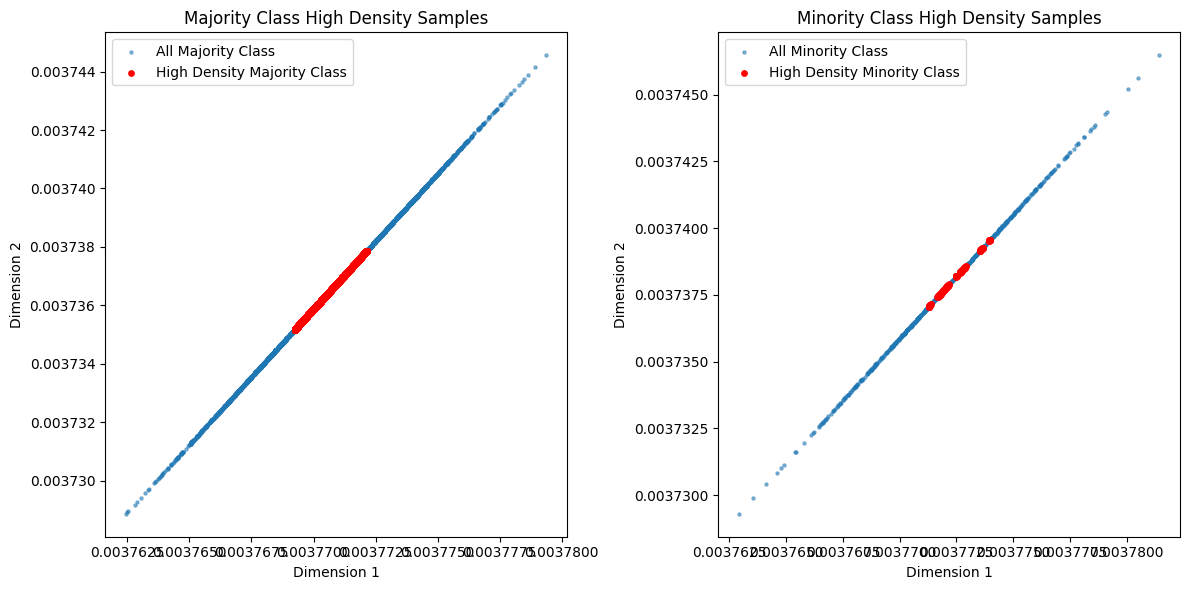

In [28]:
# 시각화
plt.figure(figsize=(12, 6))

# majority class 밀도 기준 상위 샘플 시각화
plt.subplot(1, 2, 1)
plt.scatter(z_majority[:, 0], z_majority[:, 1], s=5, alpha=0.5, label='All Majority Class')
plt.scatter(high_density_majority[:, 0], high_density_majority[:, 1], s=15, color='red', label='High Density Majority Class')
plt.title('Majority Class High Density Samples')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()

# minority class 밀도 기준 상위 샘플 시각화
plt.subplot(1, 2, 2)
plt.scatter(z_minority[:, 0], z_minority[:, 1], s=5, alpha=0.5, label='All Minority Class')
plt.scatter(high_density_minority[:, 0], high_density_minority[:, 1], s=15, color='red', label='High Density Minority Class')
plt.title('Minority Class High Density Samples')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()

plt.tight_layout()
plt.show()

## 3-2.KDE 시각화

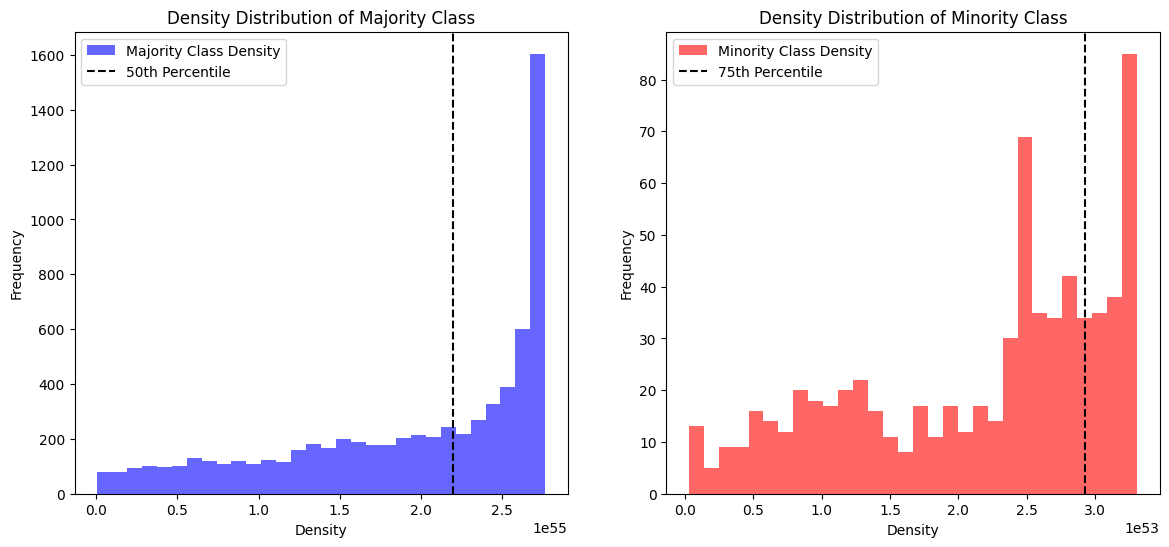

In [49]:
# 밀도 분포 시각화
plt.figure(figsize=(14, 6))

# 다수 클래스 밀도 분포
plt.subplot(1, 2, 1)
plt.hist(density_majority, bins=30, alpha=0.6, color='blue', label='Majority Class Density')
plt.axvline(np.percentile(density_majority, 50), color='k', linestyle='--', label='50th Percentile')
plt.title('Density Distribution of Majority Class')
plt.xlabel('Density')
plt.ylabel('Frequency')
plt.legend()

# 소수 클래스 밀도 분포
plt.subplot(1, 2, 2)
plt.hist(density_minority, bins=30, alpha=0.6, color='red', label='Minority Class Density')
plt.axvline(np.percentile(density_minority, 75), color='k', linestyle='--', label='75th Percentile')
plt.title('Density Distribution of Minority Class')
plt.xlabel('Density')
plt.ylabel('Frequency')
plt.legend()

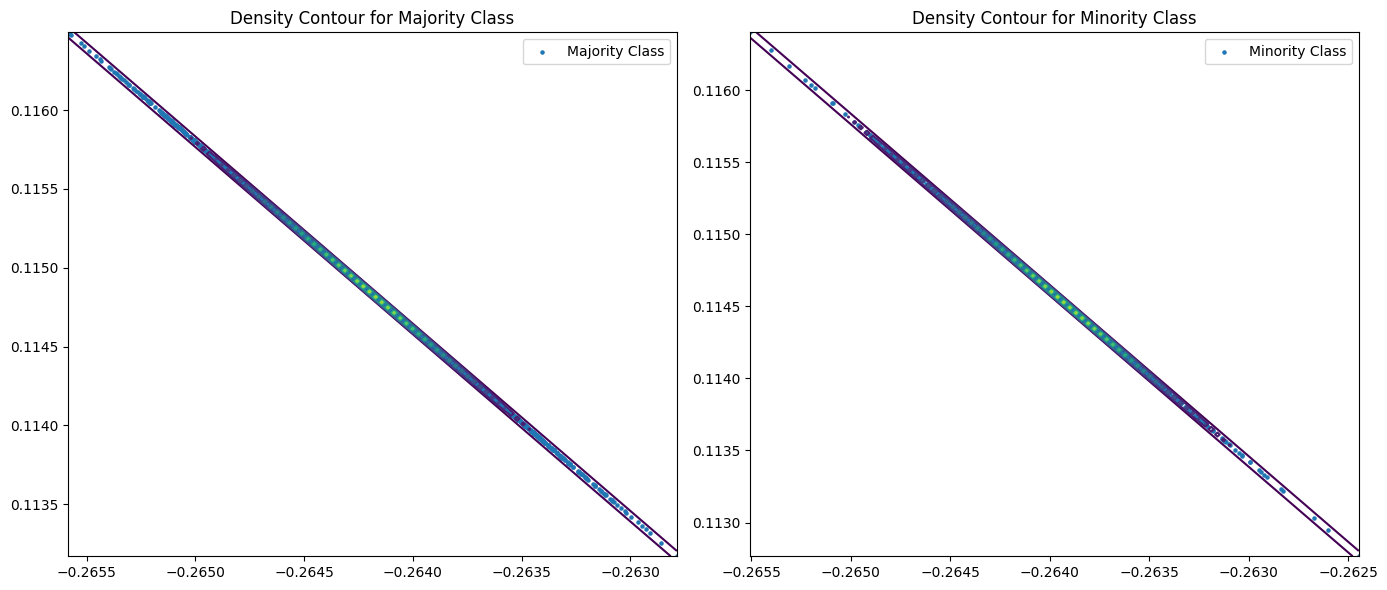

In [50]:
from scipy.stats import gaussian_kde
def plot_contour(data, label, ax):
    data = data.numpy()
    x = data[:, 0]
    y = data[:, 1]

    # KDE를 사용한 밀도 추정
    kde = gaussian_kde(np.vstack([x, y])) #
    xi, yi = np.mgrid[x.min():x.max():100j, y.min():y.max():100j]
    zi = kde(np.vstack([xi.flatten(), yi.flatten()]))

    # 등고선 플롯
    ax.contour(xi, yi, zi.reshape(xi.shape), levels=10)
    ax.scatter(x, y, s=5, label=label)
    ax.set_title(f'Density Contour for {label}')
    ax.legend()

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# 다수 클래스 등고선 플롯
plot_contour(z_majority, 'Majority Class', axs[0])

# 소수 클래스 등고선 플롯
plot_contour(z_minority, 'Minority Class', axs[1])

plt.tight_layout()
plt.show()

# 4. Verification of Synthetic Samples
- 샘플 데이터 검증을 위한 두 가지 기준을 정의
- 다양한 합성 샘플을 만들기 위해 feature-level sampling 기법을 사용

In [54]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity

# 클래스 중심 계산 (cM, cN)
cM = high_density_majority.mean(dim=0)
cN = high_density_minority.mean(dim=0)

# 고밀도 소수 클래스 샘플의 밀도 계산
density_high_density_minority = compute_density(high_density_minority)

# 경계 지점과 반경 r^N 계산
boundary_point = high_density_minority[density_high_density_minority.argmin()]
rN = torch.norm(boundary_point - cN, p=2).item()

# 피처 도메인 수집
feature_domains = [high_density_minority[:, i].tolist() for i in range(high_density_minority.size(1))]

# n_S
n_s = int(over_sampling_ratio * len(high_density_minority)) - num_class_1

# 합성 데이터 생성
S = []
while len(S) < n_s:
    s = []
    for domain in feature_domains:
        s.append(np.random.choice(domain))
    s = torch.tensor(s, dtype=torch.float32)

    # 검증 조건 eq. (6) & eq. (7) 확인
    if torch.norm(s - cN, p=2).item() < torch.norm(s - cM, p=2).item() and \
       torch.norm(s - cN, p=2).item() < rN:
        S.append(s)

print(len(S))
S = torch.stack(S)

# 생성된 잠재 공간의 합성 데이터를 원본 공간으로 변환
with torch.no_grad():
    S_decoded = autoencoder.decoder(S)

# 최종 데이터 결합
synthetic_data = torch.cat((data, S_decoded), dim=0)

kde ============================ KernelDensity(bandwidth=2.784556664204779e-05)
log_density ==================== [150.87691925 150.79718272 150.93346138 151.21432559 151.23101546
 150.32090744 151.1567058  151.24047777 150.90970043 151.20837012
 151.0837468  150.95246645 151.03033153 151.24902376 151.24446088
 150.87358773 151.17145335 150.76791132 150.80031435 150.95112573
 150.90715201 150.8381233  151.17117174 150.86942618 151.03006144
 151.24521896 150.9532798  151.23994014 150.8705574  151.04991056
 151.22101874 151.021466   151.23141948 151.02263789 151.03655898
 151.13396728 150.79951177 151.2422707  150.86729195 151.04796724
 149.94249133 151.02419728 151.22996495 150.9049941  151.22593138
 151.18890951 150.66248696 150.90555444 150.95305633 150.6247367
 150.91693971 150.76043256 150.89969934 151.00303272 150.8679529
 151.0374454  151.02618336 151.23025556 151.04494363 150.83343543
 151.03700017 150.94159342 150.96297995 151.07333755 151.23127416
 150.9940099  151.24010937 150.

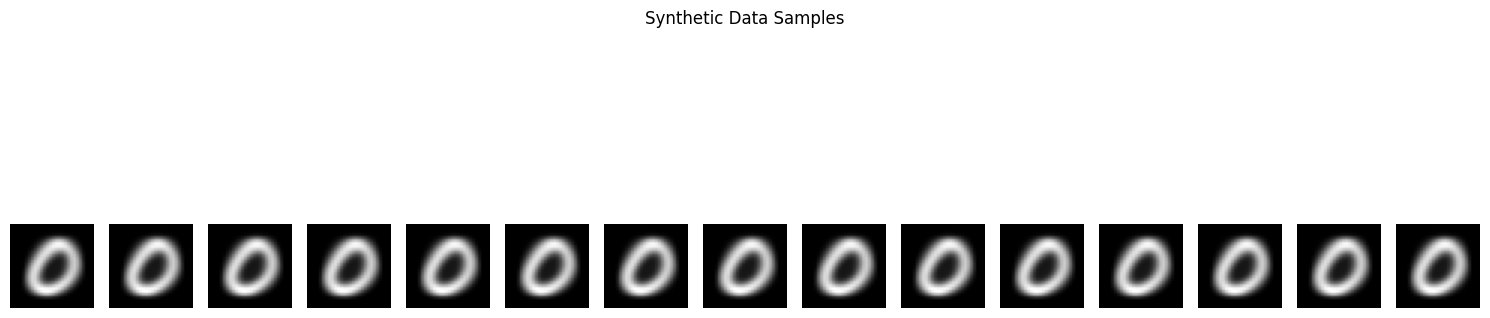

In [53]:
# 합성 데이터에 대한 레이블 생성 (여기서는 새로운 클래스 레이블을 2로 가정)
synthetic_labels = torch.full((S_decoded.size(0),), 2)

# 합성 데이터와 레이블만 시각화
def plot_synthetic_samples(data, labels, num_samples=15):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))  # 1행으로 합성 클래스
    for j in range(num_samples):
        if j < len(data):  # 시각화할 샘플이 충분한지 확인
            axes[j].imshow(data[j].reshape(28, 28), cmap='gray')
        axes[j].axis('off')
    plt.suptitle('Synthetic Data Samples')
    plt.tight_layout()
    plt.show()

# 합성 데이터 시각화
plot_synthetic_samples(S_decoded.numpy(), synthetic_labels.numpy())